## Отчет по анализу и подготовке данных ЭКГ для машинного обучения

### 1. Постановка задачи

Основная цель данного анализа - подготовить датасет с данными электрокардиограмм (ЭКГ) для последующего обучения модели машинного обучения. Задача модели - классифицировать каждую запись ЭКГ на две категории: "здоровые" (код 1) и "потенциально аномальные" (код 0).

Для достижения этой цели был выполнен полный цикл подготовки данных, включающий:
1.  **Исследование и очистку данных:** Анализ исходных данных, обнаружение и обработка пропусков и аномальных значений ("заглушек").
2.  **Генерацию признаков (Feature Engineering):** Создание новых, физиологически значимых признаков из исходных данных для повышения предсказательной силы модели.
3.  **Отбор признаков (Feature Selection):** Устранение избыточных и некоррелирующих признаков для построения более робастной и интерпретируемой модели.

### 2. Описание и первичный анализ данных

Исходный датасет `ecg_data.csv` содержит 300 записей со следующими ключевыми параметрами ЭКГ:

*   `Healthy`: Целевая переменная (1 - здоров, 0 - аномалия).
*   `rr_interval`: Длительность сердечного цикла.
*   `p_onset`, `p_end`: Временные отметки начала и конца P-волны (деполяризация предсердий).
*   `qrs_onset`, `qrs_end`: Временные отметки начала и конца QRS-комплекса (деполяризация желудочков).
*   `t_end`: Временная отметка конца T-волны (реполяризация желудочков).
*   `p_axis`, `qrs_axis`, `t_axis`: Электрические оси P, QRS и T в градусах.

**Референсные значения**:

| Параметр ЭКГ                     | Нормальный диапазон                     | Обоснование |
|----------------------------------|------------------------------------------|-------------|
| **RR-интервал**                  | 600-1000 мс                             | Отражает частоту сердечных сокращений. Значения <600 мс могут указывать на **тахикардию**, >1000 мс - на **брадикардию**. |
| **Длительность P-волны**         | 60-120 мс                               | Характеризует деполяризацию предсердий. Увеличение длительности может свидетельствовать о **гипертрофии или дилатации предсердий**. |
| **Длительность QRS-комплекса**   | 60-110 мс                               | Отражает деполяризацию желудочков. Расширение (>110 мс) может указывать на **нарушения внутрижелудочковой проводимости** (например, блокады ножек пучка Гиса). |
| **Корректированный QT (QTc)**    | Мужчины: <450 мс<br>Женщины: <470 мс    | Характеризует продолжительность электрической систолы желудочков. **Удлинение** связано с повышенным риском **желудочковых аритмий** (например, TdP - torsades de pointes). |
| **Электрическая ось P**          | 0° до 75°                               | Отклонения могут указывать на **нарушения проводимости в предсердиях**, эктопические ритмы или гипертрофию предсердий. |
| **Электрическая ось QRS**        | -30° до 90°                             | Выход за пределы может свидетельствовать о **гипертрофии желудочков**, **блокадах**, **инфарктах** или **декстрокардии**. |
| **Электрическая ось T**          | 0° до 90°                               | Отклонения могут указывать на **ишемию**, **гипертрофию**, **электролитные нарушения** или **вентрикулярную перегрузку**. |

**Статистики и выводы первичного анализа:**

При первичном анализе с помощью `df.info()` было установлено, что в данных (300 записей) нет формальных пропусков (`NaN`). Однако при более глубоком изучении с помощью `df.describe()` и визуального анализа были обнаружены аномально большие значения, такие как `29999` и `32767`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../data/ecg_data.csv")

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Healthy      300 non-null    int64
 1   rr_interval  300 non-null    int64
 2   p_onset      300 non-null    int64
 3   p_end        300 non-null    int64
 4   qrs_onset    300 non-null    int64
 5   qrs_end      300 non-null    int64
 6   t_end        300 non-null    int64
 7   p_axis       300 non-null    int64
 8   qrs_axis     300 non-null    int64
 9   t_axis       300 non-null    int64
dtypes: int64(10)
memory usage: 23.6 KB


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Healthy,300.0,0.806667,0.395572,0.0,1.0,1.0,1.00,1.0
rr_interval,300.0,935.936667,1692.447257,324.0,722.0,845.0,952.00,29999.0
p_onset,300.0,4471.840000,10601.152388,40.0,40.0,40.0,323.50,29999.0
p_end,300.0,8308.093333,13325.445319,76.0,144.0,158.0,29999.00,29999.0
qrs_onset,300.0,337.850000,1721.427748,65.0,190.0,200.0,227.50,29999.0
qrs_end,300.0,437.093333,1715.743568,141.0,280.0,302.0,340.00,29999.0
t_end,300.0,738.790000,1698.748138,377.0,574.0,614.0,670.00,29999.0
p_axis,300.0,4748.510000,10928.032300,-82.0,38.0,58.0,72.25,32767.0
qrs_axis,300.0,313.400000,2988.832557,-138.0,-18.0,14.0,46.00,29999.0
t_axis,300.0,338.853333,2986.440888,-172.0,15.0,41.0,69.00,29999.0


In [4]:
df[(df > 20000).any(axis=1)]

,Healthy,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis
2,1,857,29999,29999,200,354,662,29999,-70,95
4,1,723,323,29999,504,600,915,35,-16,48
10,1,324,371,29999,503,585,873,93,21,117
12,1,504,385,29999,507,649,873,18,-75,28
13,1,800,314,29999,499,595,859,6,57,-19
...,...,...,...,...,...,...,...,...,...,...
286,1,674,294,29999,502,583,869,70,68,-4
287,1,652,29999,29999,200,292,594,29999,-21,7
288,1,625,284,29999,506,597,888,57,27,44
295,1,938,352,29999,499,613,898,55,51,57


In [5]:
df_nan = df.where(df <= 5000, np.nan)

In [6]:
df_nan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Healthy      300 non-null    int64  
 1   rr_interval  299 non-null    float64
 2   p_onset      256 non-null    float64
 3   p_end        218 non-null    float64
 4   qrs_onset    299 non-null    float64
 5   qrs_end      299 non-null    float64
 6   t_end        299 non-null    float64
 7   p_axis       253 non-null    float64
 8   qrs_axis     297 non-null    float64
 9   t_axis       297 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 23.6 KB


In [7]:
cols_nan = df_nan.columns[df_nan.isnull().any(axis=0)].tolist()

print("Количество пропущенных значений:")
print(df_nan[cols_nan].isnull().sum())

print("\nКомбинации пропущенных значений:")
nan_mask = df_nan[cols_nan].isnull()
combo_counts = nan_mask[nan_mask.any(axis=1)].value_counts().sort_values(ascending=False)

for combo, cnt in combo_counts.items():
    missing_cols = tuple(col for col, is_nan in zip(cols_nan, combo) if is_nan)
    print(f"  {missing_cols}: {cnt}")

Количество пропущенных значений:
rr_interval     1
p_onset        44
p_end          82
qrs_onset       1
qrs_end         1
t_end           1
p_axis         47
qrs_axis        3
t_axis          3
dtype: int64

Комбинации пропущенных значений:
  ('p_onset', 'p_end', 'p_axis'): 43
  ('p_end',): 37
  ('p_axis', 'qrs_axis', 't_axis'): 2
  ('p_end', 'p_axis'): 1
  ('rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis'): 1


**Вывод:** Эти значения являются "заглушками", используемыми для обозначения пропущенных данных. 84 из 300 строк содержат как минимум одну такую заглушку. Прямое использование этих данных в модели приведет к неверным результатам, поэтому необходима их очистка.

### 3. Очистка данных и предобработка

Процесс очистки был направлен на решение двух основных проблем: "заглушки" и потенциальные выбросы.

1.  **Замена "заглушек"**: Все аномальные значения (`29999`, `32767`) были заменены на `np.nan` для корректной обработки как пропущенных значений.
2.  **Обработка выбросов**: Для ограничения влияния экстремальных значений, особенно в `RR_interval` и производных интервалах, был применен метод *Winsorizing*. Этот метод "подрезает" значения, выходящие за пределы заданных квантилей (например, 1% и 99%), заменяя их на граничные значения. Это делает данные более устойчивыми к выбросам.
3.  **Иерархическая импутация пропусков**: Для заполнения пропусков была применена иерархическая стратегия, сохраняющая физиологические связи между параметрами ЭКГ:
    *   Сначала восстанавливались ключевые интервалы (`QRS_interval`), используя медианные значения на основе `RR_interval`.
    *   Затем, опираясь на восстановленные QRS-комплексы, импутировались временные отметки P и T волн.
    *   Оставшиеся пропуски заполнялись медианными значениями по всему датасету или референсными значениями.

**Вывод:** После очистки получается датасет без аномальных "заглушек", с обработанными выбросами и логически заполненными пропусками, готовый для следующего этапа - генерации признаков.

### 4. Генерация новых признаков

На основе очищенных данных было создано несколько категорий новых признаков для выявления скрытых закономерностей.

#### Категория 1: Пропорции и Отношения (Нормализация по сердечному ритму)
*   **Признаки**: `PR_RR_Ratio`, `QRS_RR_Ratio`, `STT_RR_Ratio`.
*   **Цель**: Сделать длительности фаз ЭКГ независимыми от частоты сердечных сокращений (ЧСС). Например, аномально длинный QRS-комплекс может быть более значимым при высокой ЧСС. Эти признаки нормализуют интервалы относительно длины всего сердечного цикла (`RR_interval`).

#### Категория 2: Взаимосвязь Электрических Осей
*   **Признаки**: `QRS_T_Axis_Diff`, `P_QRS_Axis_Diff`, `Is_QRS_T_Concordant`.
*   **Цель**: Оценить согласованность процессов деполяризации и реполяризации. Большой угол между осями QRS и T (`QRS_T_Axis_Diff`) является мощным неспецифическим признаком патологии (ишемия, гипертрофия). Признак `Is_QRS_T_Concordant` является его бинарной версией. Также оси были преобразованы в синусные и косинусные компоненты (`P_axis_sin`, `P_axis_cos` и т.д.), чтобы модели, основанные на деревьях, могли корректно работать с циклическими данными (углами).

#### Категория 3: Полиномиальные и Interaction-признаки
*   **Признаки**: `QTc_Squared`, `QRS_RR_Interaction`.
*   **Цель**: Помочь модели уловить нелинейные зависимости.
    *   `QTc_Squared`: Как аномально короткий, так и аномально длинный интервал QTc опасен. Квадратичный признак позволяет линейным моделям одинаково штрафовать за отклонения в обе стороны от нормы.
    *   `QRS_RR_Interaction`: Позволяет модели понять, что влияние длительности QRS на целевую переменную зависит от текущего сердечного ритма.

Ниже представлен унифицированный код, который выполняет всю очистку, импутацию и генерацию признаков.

In [8]:
import pandas as pd
import numpy as np
from typing import Dict, Any, Tuple, List

# Справочные диапазоны, используемые как значения по умолчанию при импутации.
REFERENCE_RANGES: Dict[str, Tuple[int, int]] = {
    'P_interval': (60, 120),
    'PR_interval': (120, 200),
    'QRS_interval': (60, 110),
    'QT_interval': (350, 450)
}

# Магические числа (значения-заглушки) и колонки, где они могут встречаться.
MAGIC_NUMBERS: List[int] = [29999, 32767]
RAW_FEATURE_COLS: List[str] = [
    'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end',
    'p_axis', 'qrs_axis', 't_axis', 'rr_interval'
]

In [9]:
def _angle_to_sin_cos(angle_deg: pd.Series) -> Tuple[pd.Series, pd.Series]:
    """Преобразует столбец с углами в градусах в синусную и косинусную компоненты.

    Args:
        angle_deg: Серия pandas с угловыми значениями в градусах.

    Returns:
        Кортеж из двух серий pandas: (синус, косинус).
    """
    rad = np.radians(angle_deg)
    return np.sin(rad), np.cos(rad)

In [10]:
def _cyclical_angle_difference(angle1_deg: pd.Series, angle2_deg: pd.Series) -> pd.Series:
    """Корректно вычисляет кратчайшую разницу между двумя углами.

    Результат всегда находится в диапазоне [0, 180], представляя
    величину углового расхождения.

    Args:
        angle1_deg: Серия pandas с первым набором углов.
        angle2_deg: Серия pandas со вторым набором углов.

    Returns:
        Серия pandas с абсолютной циклической разницей.
    """
    diff = np.abs(angle1_deg - angle2_deg)
    return np.where(diff > 180, 360 - diff, diff)

In [11]:
def create_preprocessing_statistics(
    df: pd.DataFrame,
    ref_ranges: Dict[str, Tuple[int, int]],
    winsor_quantiles: Tuple[float, float] = (0.01, 0.99)
) -> Dict[str, Any]:
    """
    "Обучает" препроцессор: собирает все необходимые статистики на обучающих данных.

    Args:
        df: Обучающий DataFrame с "сырыми" временными точками и признаками.
        ref_ranges: Словарь со справочными диапазонами для интервалов.
        winsor_quantiles: Кортеж с нижним и верхним квантилями для Winsorization.

    Returns:
        Словарь со статистиками, готовый для использования в функции transform_ecg_data.
    """
    stats = {
        'medians': {},
        'mads': {},
        'derived_medians': {},
        'ref_defaults': {k: np.mean(v) for k, v in ref_ranges.items()},
        'winsor_limits': {}
    }

    # Очистка от магических чисел ПЕРЕД расчетом статистик.
    df_clean = df.copy()
    for col in RAW_FEATURE_COLS:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].replace(MAGIC_NUMBERS, np.nan)

    # Статистики для "сырых" признаков (теперь на очищенных данных)
    for col in df_clean.columns:
        if pd.api.types.is_numeric_dtype(df_clean[col]):
            x = df_clean[col].dropna()
            if not x.empty:
                stats['medians'][col] = x.median()
                stats['mads'][col] = np.median(np.abs(x - x.median()))

    # Статистики для производных интервалов и RR (для Winsorization)
    temp_df = df_clean.copy()
    temp_df['P_interval'] = temp_df['p_end'] - temp_df['p_onset']
    temp_df['PR_interval'] = temp_df['qrs_onset'] - temp_df['p_onset']
    temp_df['QRS_interval'] = temp_df['qrs_end'] - temp_df['qrs_onset']
    temp_df['QT_interval'] = temp_df['t_end'] - temp_df['qrs_onset']
    temp_df['ST_T_interval'] = temp_df['t_end'] - temp_df['qrs_end']

    derived_cols = ['P_interval', 'PR_interval', 'QRS_interval', 'QT_interval', 'ST_T_interval', 'rr_interval']
    for col in derived_cols:
        source_col = df_clean[col] if col == 'rr_interval' else temp_df[col]
        x = source_col.dropna()
        if not x.empty and np.std(x) > 0:
            stats['derived_medians'][col] = x.median()
            low, high = x.quantile(winsor_quantiles)
            stats['winsor_limits'][col] = (low, high)

    return stats

In [12]:
def transform_ecg_data(
    df: pd.DataFrame,
    stats: Dict[str, Any],
    std_threshold: float = 5.0
) -> pd.DataFrame:
    """
    Применяет полный пайплайн очистки, импутации и генерации признаков.

    Args:
        df: DataFrame для обработки (train или test).
        stats: Словарь со статистиками, полученный от create_preprocessing_statistics.
        std_threshold: Порог для робастного Z-score для определения выбросов.

    Returns:
        DataFrame с полным набором финальных признаков.
    """
    df_proc = df.copy()
    ref = stats['ref_defaults']
    medians = stats['medians']
    derived_medians = stats.get('derived_medians', {})

    # Замена магических чисел и создание соответствующих флагов.
    for col in RAW_FEATURE_COLS:
        if col in df_proc.columns:
            df_proc[f'{col}_was_magic'] = df_proc[col].isin(MAGIC_NUMBERS).astype(int)
            df_proc[col] = df_proc[col].replace(MAGIC_NUMBERS, np.nan)

    # Создание флагов изначальных пропусков.
    for col in RAW_FEATURE_COLS:
        if col in df_proc.columns:
            df_proc[f'{col}_was_missing'] = df_proc[col].isna().astype(int)

    # Очистка выбросов в сырых данных.
    for col in RAW_FEATURE_COLS:
        if col in medians and col in stats['mads'] and stats['mads'][col] > 0:
            z = 0.6745 * (df_proc[col] - medians[col]) / stats['mads'][col]
            df_proc.loc[np.abs(z) > std_threshold, col] = np.nan

    # Winsorization для RR-интервала ДО его использования.
    if 'rr_interval' in stats['winsor_limits']:
        low, high = stats['winsor_limits']['rr_interval']
        before = df_proc['rr_interval'].copy()
        df_proc['rr_interval'] = df_proc['rr_interval'].clip(lower=low, upper=high)
        df_proc['rr_interval_was_winsorized'] = ((before < low) | (before > high)).astype(int)

    # Иерархическая импутация с точными флагами.
    for col in RAW_FEATURE_COLS:
        if col in df_proc.columns:
            df_proc[f'{col}_was_imputed'] = df_proc[col].isna().astype(int)

    qrs_missing_mask = df_proc['qrs_onset'].isna() & df_proc['qrs_end'].isna()
    if qrs_missing_mask.any():
        rr_impute_val = medians.get('rr_interval', 800)
        df_proc.loc[qrs_missing_mask, 'rr_interval'] = df_proc.loc[qrs_missing_mask, 'rr_interval'].fillna(rr_impute_val)
        rr_midpoint = df_proc.loc[qrs_missing_mask, 'rr_interval'] * 0.5
        qrs_dur_half = derived_medians.get('QRS_interval', ref['QRS_interval']) / 2
        df_proc.loc[qrs_missing_mask, 'qrs_onset'] = rr_midpoint - qrs_dur_half
        df_proc.loc[qrs_missing_mask, 'qrs_end'] = rr_midpoint + qrs_dur_half

    df_proc['qrs_end'].fillna(df_proc['qrs_onset'] + derived_medians.get('QRS_interval', ref['QRS_interval']), inplace=True)
    df_proc['qrs_onset'].fillna(df_proc['qrs_end'] - derived_medians.get('QRS_interval', ref['QRS_interval']), inplace=True)

    reliable_qrs_mask = (df_proc['qrs_onset_was_imputed'] == 0) & (df_proc['qrs_end_was_imputed'] == 0)
    df_proc.loc[reliable_qrs_mask, 'p_onset'] = df_proc.loc[reliable_qrs_mask, 'p_onset'].fillna(df_proc['qrs_onset'] - derived_medians.get('PR_interval', ref['PR_interval']))
    df_proc.loc[reliable_qrs_mask, 't_end'] = df_proc.loc[reliable_qrs_mask, 't_end'].fillna(df_proc['qrs_onset'] + derived_medians.get('QT_interval', ref['QT_interval']))

    df_proc['p_onset'].fillna(medians.get('p_onset'), inplace=True)
    df_proc['p_end'].fillna(df_proc['p_onset'] + derived_medians.get('P_interval', ref['P_interval']), inplace=True)
    df_proc['t_end'].fillna(medians.get('t_end'), inplace=True)

    impute_dict = {col: medians[col] for col in ['p_axis', 'qrs_axis', 't_axis', 'rr_interval'] if col in medians}
    df_proc.fillna(impute_dict, inplace=True)

    for start, end, interval_ref in [('p_onset', 'p_end', 'P_interval'), ('qrs_onset', 'qrs_end', 'QRS_interval')]:
        mask = df_proc[end] <= df_proc[start]
        median_interval = derived_medians.get(interval_ref, ref[interval_ref])
        df_proc.loc[mask, end] = df_proc.loc[mask, start] + median_interval
    mask = df_proc['qrs_onset'] <= df_proc['p_end']
    if mask.any():
        pr_median = derived_medians.get('PR_interval', ref['PR_interval'])
        p_median = derived_medians.get('P_interval', ref['P_interval'])
        df_proc.loc[mask, 'qrs_onset'] = df_proc.loc[mask, 'p_end'] + (pr_median - p_median)
    mask = df_proc['t_end'] <= df_proc['qrs_end']
    if mask.any():
        qt_median = derived_medians.get('QT_interval', ref['QT_interval'])
        qrs_median = derived_medians.get('QRS_interval', ref['QRS_interval'])
        df_proc.loc[mask, 't_end'] = df_proc.loc[mask, 'qrs_end'] + (qt_median - qrs_median)

    # Расчет и Winsorization производных интервалов
    df_proc['P_interval'] = df_proc['p_end'] - df_proc['p_onset']
    df_proc['PR_interval'] = df_proc['qrs_onset'] - df_proc['p_onset']
    df_proc['QRS_interval'] = df_proc['qrs_end'] - df_proc['qrs_onset']
    df_proc['QT_interval'] = df_proc['t_end'] - df_proc['qrs_onset']
    df_proc['ST_T_interval'] = df_proc['t_end'] - df_proc['qrs_end']

    pr_lt_p_mask = df_proc['PR_interval'] < df_proc['P_interval']
    if pr_lt_p_mask.any():
        pr_diff = derived_medians.get('PR_interval', ref['PR_interval']) - derived_medians.get('P_interval', ref['P_interval'])
        df_proc.loc[pr_lt_p_mask, 'PR_interval'] = df_proc.loc[pr_lt_p_mask, 'P_interval'] + pr_diff
    qt_lt_qrs_mask = df_proc['QT_interval'] < df_proc['QRS_interval']
    if qt_lt_qrs_mask.any():
        qt_diff = derived_medians.get('QT_interval', ref['QT_interval']) - derived_medians.get('QRS_interval', ref['QRS_interval'])
        df_proc.loc[qt_lt_qrs_mask, 'QT_interval'] = df_proc.loc[qt_lt_qrs_mask, 'QRS_interval'] + qt_diff

    df_proc['ST_T_was_corrected'] = (df_proc['ST_T_interval'] <= 0).astype(int)
    st_med = derived_medians.get('ST_T_interval')
    if st_med is not None:
        df_proc.loc[df_proc['ST_T_interval'] <= 0, 'ST_T_interval'] = st_med

    for col in ['P_interval', 'PR_interval', 'QRS_interval', 'QT_interval', 'ST_T_interval']:
        if col in stats['winsor_limits']:
            low, high = stats['winsor_limits'][col]
            before = df_proc[col].copy()
            df_proc[col] = df_proc[col].clip(lower=low, upper=high)
            df_proc[f'{col}_was_winsorized'] = ((before < low) | (before > high)).astype(int)

    # Генерация финальных признаков
    df_gen = df_proc.rename(columns={'rr_interval': 'RR_interval', 'p_axis': 'P_axis', 'qrs_axis': 'QRS_axis', 't_axis': 'T_axis'})
    with np.errstate(divide='ignore', invalid='ignore'):
        rr_seconds = df_gen['RR_interval'].replace(0, np.nan) / 1000.0
        df_gen['QTc'] = df_gen['QT_interval'] / np.sqrt(rr_seconds)
        df_gen['PR_RR_Ratio'] = df_gen['PR_interval'] / df_gen['RR_interval']
        df_gen['QRS_RR_Ratio'] = df_gen['QRS_interval'] / df_gen['RR_interval']
        df_gen['STT_RR_Ratio'] = df_gen['ST_T_interval'] / df_gen['RR_interval']
        df_gen['QRS_T_Axis_Diff'] = _cyclical_angle_difference(df_gen['QRS_axis'], df_gen['T_axis'])
        df_gen['P_QRS_Axis_Diff'] = _cyclical_angle_difference(df_gen['P_axis'], df_gen['QRS_axis'])
        angle_features = ['P_axis', 'QRS_axis', 'T_axis', 'QRS_T_Axis_Diff', 'P_QRS_Axis_Diff']
        for axis in angle_features:
            df_gen[f'{axis}_sin'], df_gen[f'{axis}_cos'] = _angle_to_sin_cos(df_gen[axis])
        df_gen['Is_QRS_T_Concordant'] = (df_gen['QRS_T_Axis_Diff'] < 60).astype(int)
        df_gen['QRS_RR_Interaction'] = df_gen['QRS_interval'] * df_gen['RR_interval']
        df_gen['QTc_Squared'] = df_gen['QTc']**2

    final_cols = [c for c in df_gen.columns if 'onset' not in c and 'end' not in c]
    return df_gen[final_cols]

/tmp/ipykernel_32478/728813064.py:60: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_proc['qrs_end'].fillna(df_proc['qrs_onset'] + derived_medians.get('QRS_interval', ref['QRS_interval']), inplace=True)
/tmp/ipykernel_32478/728813064.py:61: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

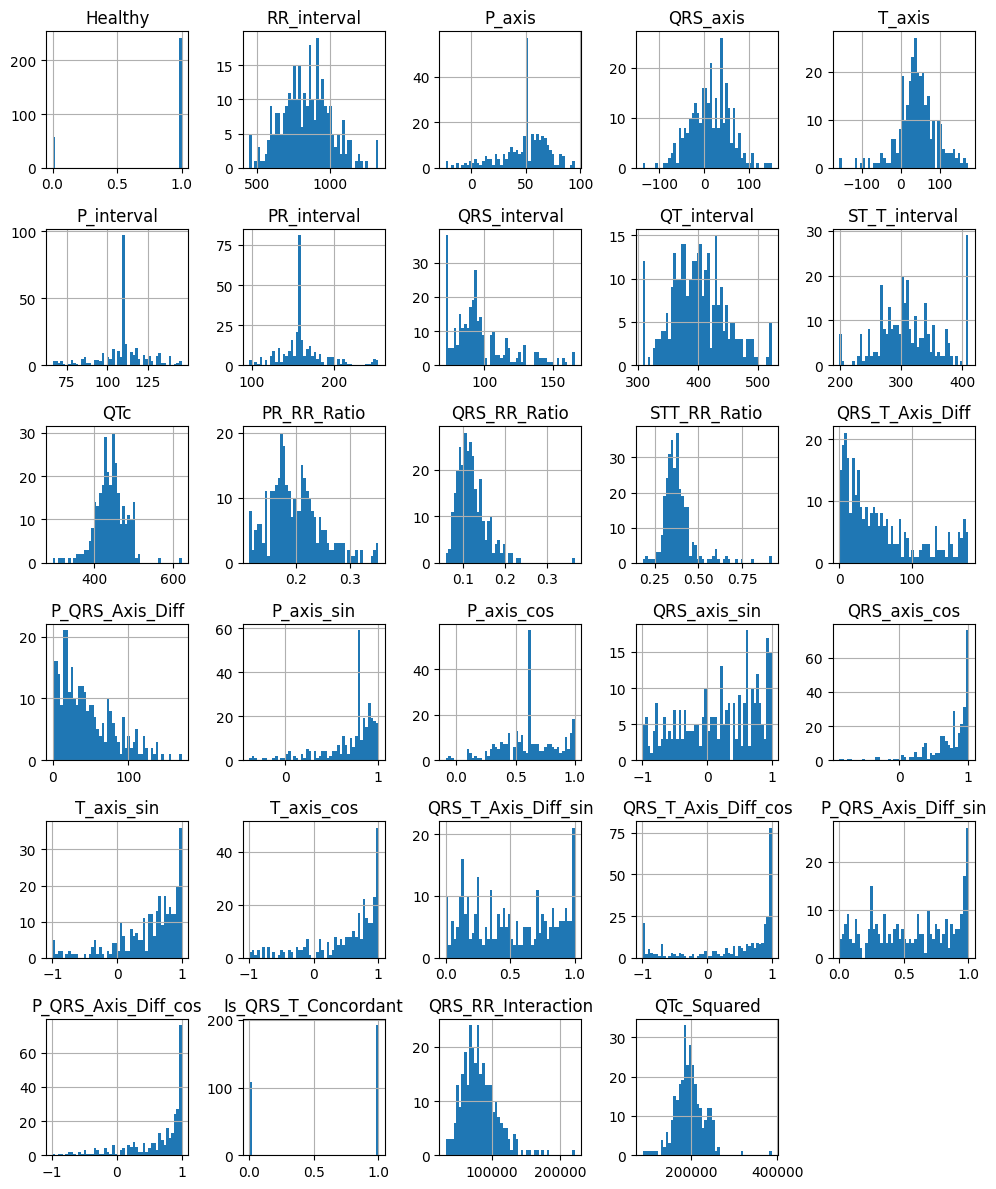

In [13]:
# Train: для аналаиза посмотрим на весь датасет
df = pd.read_csv("../data/ecg_data.csv")
processing_stats = create_preprocessing_statistics(df, REFERENCE_RANGES)
df_cleaned = transform_ecg_data(df, processing_stats)

mask = ~df_cleaned.columns.str.contains('_was_|_imputed|_winsorized|_corrected')
df_cleaned.loc[:, mask].hist(bins=50, figsize=(10, 12))
plt.tight_layout()
plt.show()

# Очистка ТЕСТа на медианах из train
# df_test_final = transform_ecg_data(df_test_raw, processing_stats)
# print(df_test_final.head())

In [14]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 48 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Healthy                       300 non-null    int64  
 1   RR_interval                   300 non-null    float64
 2   P_axis                        300 non-null    float64
 3   QRS_axis                      300 non-null    float64
 4   T_axis                        300 non-null    float64
 5   p_axis_was_magic              300 non-null    int64  
 6   qrs_axis_was_magic            300 non-null    int64  
 7   t_axis_was_magic              300 non-null    int64  
 8   rr_interval_was_magic         300 non-null    int64  
 9   p_axis_was_missing            300 non-null    int64  
 10  qrs_axis_was_missing          300 non-null    int64  
 11  t_axis_was_missing            300 non-null    int64  
 12  rr_interval_was_missing       300 non-null    int64  
 13  rr_in

In [15]:
df_cleaned.describe().T

,count,mean,std,min,25%,50%,75%,max
Healthy,300.0,0.806667,0.395572,0.000000,1.000000,1.000000,1.000000,1.000000
RR_interval,300.0,839.237600,170.783789,446.760000,722.000000,845.000000,952.000000,1333.000000
P_axis,300.0,48.456667,22.297505,-23.000000,38.000000,52.000000,64.000000,95.000000
QRS_axis,300.0,13.540000,44.581612,-138.000000,-18.000000,13.000000,45.000000,151.000000
T_axis,300.0,41.343333,50.697003,-159.000000,15.750000,40.000000,68.000000,174.000000
p_axis_was_magic,300.0,0.156667,0.364094,0.000000,0.000000,0.000000,0.000000,1.000000
qrs_axis_was_magic,300.0,0.010000,0.099665,0.000000,0.000000,0.000000,0.000000,1.000000
t_axis_was_magic,300.0,0.010000,0.099665,0.000000,0.000000,0.000000,0.000000,1.000000
rr_interval_was_magic,300.0,0.003333,0.057735,0.000000,0.000000,0.000000,0.000000,1.000000
p_axis_was_missing,300.0,0.156667,0.364094,0.000000,0.000000,0.000000,0.000000,1.000000


**Распределение классов**

- **242 пациента (80.67%)** помечены как здоровые (`Healthy = 1`),
- **58 пациентов (19.33%)** помечены как больные (`Healthy = 0`).

Датасет **несбалансирован**: здоровых пациентов значительно больше, чем больных.

**RR-интервал** (мс)

- Среднее: 839.2 мс
- Медиана: 845.0 мс
- Стандартное отклонение: 170.8 мс
- Диапазон: 446.8 - 1333.0 мс

Распределение слегка смещено влево (медиана > среднего). Большинство значений лежит в физиологичном диапазоне (600-1000 мс).  
**Выбросы влево**: 446.8 мс - соответствует тахикардии (>134 уд/мин),  
**Выбросы вправо** 1333.0 мс - соответствует выраженной брадикардии (<45 уд/мин).  

**P-интервал** (мс)

- Среднее: 109.5 мс
- Медиана: 110.0 мс
- Стандартное отклонение: 15.4 мс
- Диапазон: 66.3 - 145.7 мс

Распределение близко к нормальному. Пик приходится на 110 мс - в пределах нормы (60-120 мс).  
**Выбросы вправо**: значения до 145.7 мс - могут указывать на замедление внутрипредсердной проводимости. Таких случаев немного, но они присутствуют.


**PR-интервал** (мс)

- Среднее: 161.1 мс
- Медиана: 157.0 мс
- Стандартное отклонение: 27.7 мс
- Диапазон: 96.8 - 253.6 мс

Распределение с правосторонним хвостом. Большинство значений - в пределах нормы (120-200 мс).  
**Выбросы вправо**: значения до 253.6 мс - превышают верхнюю границу нормы, что может указывать на AV-блокаду I степени.  
**Выбросы влево**: 96.8 мс - возможны при укороченном PR (например, синдром WPW), но единичны.


**QRS-интервал** (мс)

- Среднее: 97.0 мс
- Медиана: 93.0 мс
- Стандартное отклонение: 21.3 мс
- Диапазон: 72.0 - 166.1 мс

Распределение с выраженным правосторонним смещением.  
**Выбросы вправо**: значения до 166.1 мс - значительно превышают верхнюю границу нормы (110 мс).  

**QT-интервал** (мс)

- Среднее: 400.2 мс
- Медиана: 397.0 мс
- Стандартное отклонение: 45.0 мс
- Диапазон: 307.4 - 522.2 мс

Распределение с умеренным правосторонним хвостом - ожидаемо, так как QT зависит от ЧСС.  
**Выбросы вправо**: значения до 522.2 мс - выходят за пределы нормы даже с учётом коррекции. Могут указывать на риск аритмий.  
**Выбросы влево**: 307.4 мс - возможны при тахикардии, не являются патологией.


**ST-T интервал** (мс)

- Среднее: 313.3 мс
- Медиана: 308.0 мс
- Стандартное отклонение: 50.5 мс
- Диапазон: 197.9 - 410.2 мс

Распределение умеренно скошено вправо.  
**Выбросы вправо**: до 410.2 мс - могут отражать удлинённую фазу реполяризации.  
**Выбросы влево**: до 197.9 мс - вероятно, связаны с высокой ЧСС.  


**P_axis** (градусы)

- Среднее: 48.5°
- Медиана: 52.0°
- Стандартное отклонение: 22.3°
- Диапазон: -23.0° - 95.0°

Распределение с левосторонним смещением. Большинство значений - в пределах нормы (0-75°).  
**Выбросы влево**: -23.0° - выходят за нижнюю границу, могут быть связаны с эктопическим ритмом или артефактами.  
**Выбросы вправо**: 95.0° - находятся на верхней границе нормы.


**QRS_axis** (градусы)

- Среднее: 13.5°
- Медиана: 13.0°
- Стандартное отклонение: 44.6°
- Диапазон: -138.0° - 151.0°

Распределение широкое, с тяжёлыми хвостами в обе стороны.  
**Выбросы**:  
- Влево: -138.0° - соответствует выраженной левограмме,  
- Вправо: 151.0° - соответствует правограмме.  

**T_axis** (градусы)

- Среднее: 41.3°
- Медиана: 40.0°
- Стандартное отклонение: 50.7°
- Диапазон: -159.0° - 174.0°

Распределение **сильно смещено**, с выраженными выбросами в обе стороны.  
**Выбросы**:  
- Влево: -159.0° - глубокая инверсия T,  
- Вправо: 174.0° - крайняя правограмма T.  
Большинство значений вне клинической нормы (0-90°). Это может быть связано с:  
- техническими артефактами автоматического определения T-волны,  
- истинными нарушениями реполяризации.  


**Корректированный QT (QTc)**

- Среднее: 440.6 мс
- Медиана: 440.6 мс
- Стандартное отклонение: 38.6 мс
- Диапазон: 294.3 - 621.5 мс

Распределение симметричное, пик около 440 мс - в пределах нормы для мужчин (<450 мс).  
**Выбросы вправо**: до 621.5 мс - значительное удлинение, связанное с высоким риском аритмий.  
**Выбросы влево**: 294.3 мс - возможны при тахикардии, не являются патологией.  

### 5. Отбор признаков

После генерации большого количества признаков возникла необходимость отобрать наиболее значимые и удалить избыточные (сильно коррелирующие).

#### 1. Анализ корреляций
Тепловая карта корреляций показала сильные взаимосвязи между ожидаемыми группами признаков:
*   **Группа QT**: `QT_interval`, `ST_T_interval` и `RR_interval` сильно коррелируют, так как все они зависят от длины сердечного цикла.
*   **Группа QRS-T Axis**: `QRS_T_Axis_Diff` и `Is_QRS_T_Concordant` имеют почти идеальную отрицательную корреляцию (-0.84), так как один является бинарной версией другого.
*   **RR_interval vs Ratios**: `RR_interval` сильно отрицательно коррелирует с признаками-отношениями (`PR_RR_Ratio`, и т.д.), так как он находится в их знаменателе.





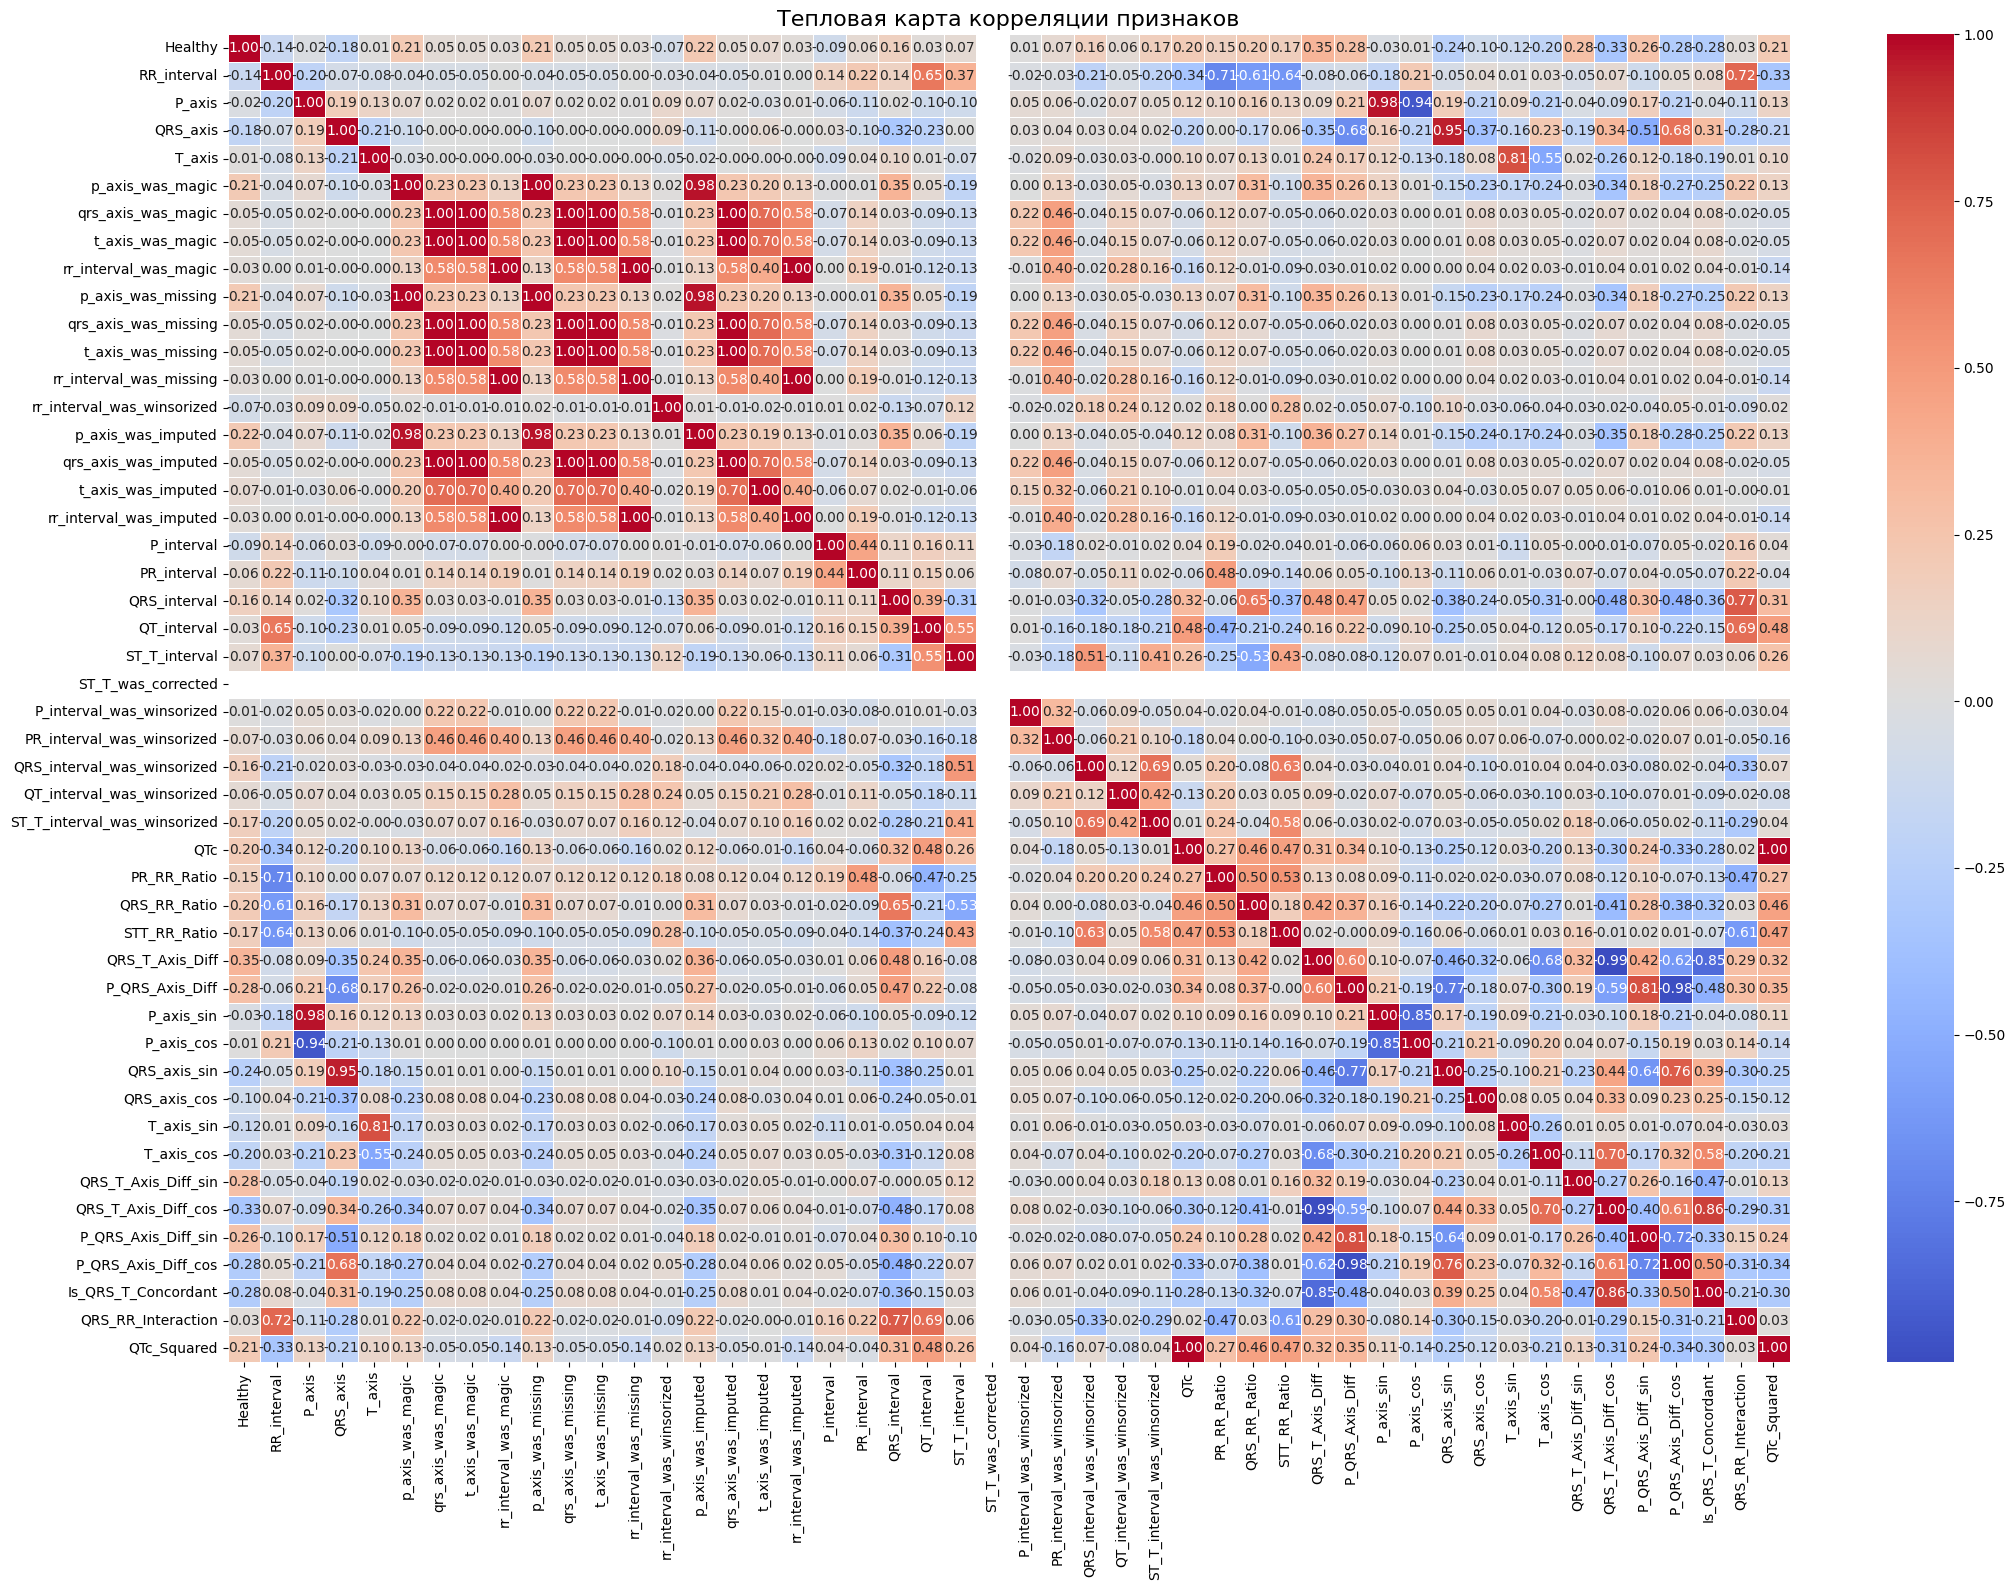

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df_cleaned.corr()

plt.figure(figsize=(22, 16))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Тепловая карта корреляции признаков', fontsize=16)
plt.tight_layout()
plt.show()

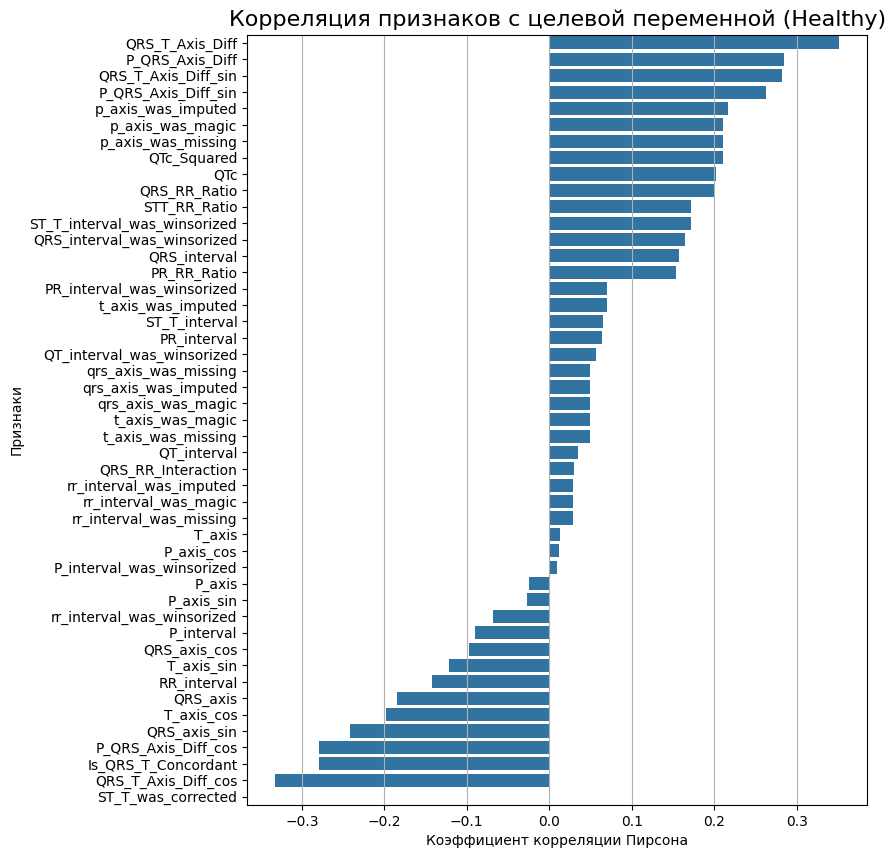

In [17]:
target_corr = df_cleaned.corr()['Healthy'].sort_values(ascending=False)

target_corr = target_corr.drop('Healthy')

plt.figure(figsize=(8, 10))
sns.barplot(x=target_corr.values, y=target_corr.index, legend=False)
plt.title('Корреляция признаков с целевой переменной (Healthy)', fontsize=16)
plt.xlabel('Коэффициент корреляции Пирсона')
plt.ylabel('Признаки')
plt.grid(True, axis='x')
plt.show()

#### 2. Автоматизированный отбор
Для отбора признаков использовался двухэтапный подход:

**Этап 1: Кластеризация для борьбы с мультиколлинеарностью**
*   **Метод**: Признаки с высокой взаимной корреляцией (порог > 0.8) были сгруппированы в кластеры. Из каждого кластера был выбран только один, наиболее важный признак (важность определялась предварительно обученной моделью RandomForest).
*   **Результат**: Этот шаг позволил удалить 16 избыточных признаков, таких как `Is_QRS_T_Concordant` (дублирует `QRS_T_Axis_Diff`), `P_axis_sin`/`cos` (дублируют `P_axis`), `QTc` (дублирует `QTc_Squared`) и флаги обработки. Количество признаков сократилось до 31.

**Этап 2: Отбор с помощью алгоритма Boruta**
*   **Метод**: Boruta — это продвинутый алгоритм отбора, который итеративно сравнивает важность каждого признака с важностью его случайных "теней". Это позволяет с высокой уверенностью определить, является ли признак действительно полезным для модели.
*   **Результат**: Алгоритм подтвердил 14 признаков как значимые, 2 признака (`PR_RR_Ratio`, `QRS_axis_cos`) остались "спорными" (Tentative), а 15 были отклонены как незначимые.

**Финальный набор признаков (14 подтвержденных):**
```
['T_axis', 'QRS_interval', 'STT_RR_Ratio', 'QTc_Squared', 'ST_T_interval', 
 'QRS_RR_Ratio', 'QRS_axis', 'P_QRS_Axis_Diff_cos', 'P_QRS_Axis_Diff_sin', 
 'QRS_T_Axis_Diff', 'T_axis_cos', 'QRS_T_Axis_Diff_sin', 'P_interval', 'PR_interval']

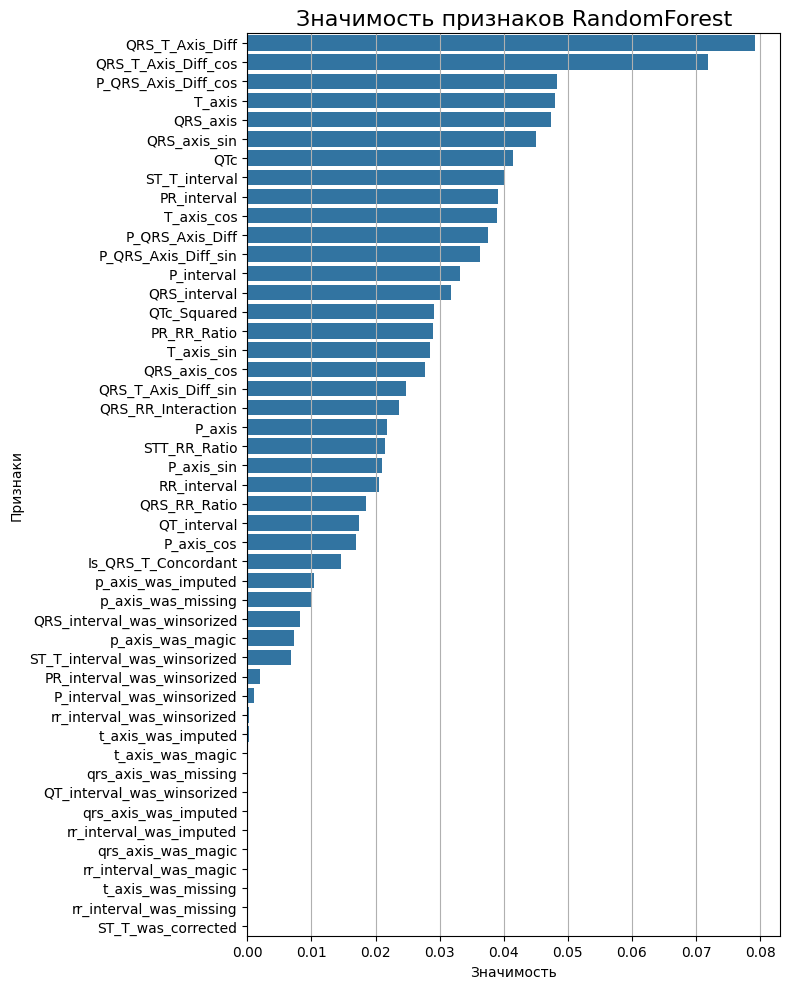

In [18]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
X = df_cleaned.drop(["Healthy"], axis=1)
y = df_cleaned["Healthy"]
model.fit(X, y)

importances = model.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, legend=False)
plt.title('Значимость признаков RandomForest', fontsize=16)
plt.xlabel('Значимость')
plt.ylabel('Признаки')
plt.grid(True, axis='x')
plt.tight_layout() 
plt.show()

In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import linkage, fcluster
from typing import Dict, Any, List

def handle_multicollinearity_clustered(
    df: pd.DataFrame,
    target_col: str,
    threshold: float = 0.9
) -> pd.DataFrame:
    """
    Находит и удаляет сильно скоррелированные признаки с использованием кластеризации.
    Эта версия гарантированно обходит ошибки симметрии, создавая сжатую
    матрицу расстояний вручную.

    Args:
        df: DataFrame с признаками и целевой переменной.
        target_col: Название целевой переменной.
        threshold: Порог корреляции для группировки признаков (от 0 до 1).

    Returns:
        DataFrame с уменьшенным количеством признаков.
    """
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Защита от малого числа признаков
    if X.shape[1] <= 1:
        print("Меньше двух признаков - кластеризация не требуется.")
        return df

    # 1. Обучаем предварительную модель для оценки важности каждого признака.
    prelim_model = RandomForestClassifier(
        n_estimators=50,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    )
    prelim_model.fit(X, y)
    importances = pd.Series(prelim_model.feature_importances_, index=X.columns)

    # 2. Создаем матрицу расстояний и кластеризуем признаки.
    corr_matrix = X.corr().abs().fillna(0).clip(0, 1).to_numpy()
    distance_matrix = 1 - corr_matrix

    # --- ОКОНЧАТЕЛЬНОЕ ИСПРАВЛЕНИЕ: Ручное создание сжатой матрицы ---
    n = distance_matrix.shape[0]
    upper_triangle_indices = np.triu_indices(n, k=1)
    condensed_distance_matrix = distance_matrix[upper_triangle_indices]

    print(f"Кластеризация {n} признаков...")
    Z = linkage(condensed_distance_matrix, method='average')

    # fcluster формирует плоские кластеры на основе порога расстояния.
    max_distance = 1 - threshold
    clusters = fcluster(Z, max_distance, criterion='distance')

    # 3. Для каждого кластера выбираем один лучший признак.
    feature_clusters = pd.DataFrame({'feature': X.columns, 'cluster': clusters})
    to_keep = []

    print("--- Анализ кластеров коллинеарных признаков ---")
    for cluster_id in sorted(feature_clusters['cluster'].unique()):
        cluster_features = feature_clusters[
            feature_clusters['cluster'] == cluster_id
        ]['feature'].tolist()

        if len(cluster_features) > 1:
            cluster_importances = importances.loc[cluster_features]
            best_feature = cluster_importances.idxmax()
            print(f"Кластер {cluster_id}: {cluster_features}.")
            print(f"\t-> Выбран представитель: '{best_feature}' (наибольшая важность)")
        else:
            best_feature = cluster_features[0]

        to_keep.append(best_feature)

    to_drop = set(X.columns) - set(to_keep)
    if to_drop:
        print(f"\nУдалено признаков: {len(to_drop)}: {sorted(to_drop)}")
    print(f"Всего признаков оставлено после кластеризации: {len(to_keep)}")

    return df[to_keep + [target_col]]

df_reduced = handle_multicollinearity_clustered(df_cleaned, 'Healthy', threshold=0.9)
df_reduced.describe().T
X_reduced = df_reduced.drop('Healthy', axis=1)
y_reduced = df_reduced['Healthy']

Кластеризация 47 признаков...
--- Анализ кластеров коллинеарных признаков ---
Кластер 3: ['P_axis', 'P_axis_sin'].
	-> Выбран представитель: 'P_axis' (наибольшая важность)
Кластер 10: ['QTc', 'QTc_Squared'].
	-> Выбран представитель: 'QTc_Squared' (наибольшая важность)
Кластер 16: ['QRS_axis', 'QRS_axis_sin'].
	-> Выбран представитель: 'QRS_axis' (наибольшая важность)
Кластер 17: ['P_QRS_Axis_Diff', 'P_QRS_Axis_Diff_cos'].
	-> Выбран представитель: 'P_QRS_Axis_Diff_cos' (наибольшая важность)
Кластер 19: ['QRS_T_Axis_Diff', 'QRS_T_Axis_Diff_cos'].
	-> Выбран представитель: 'QRS_T_Axis_Diff' (наибольшая важность)
Кластер 23: ['p_axis_was_magic', 'p_axis_was_missing', 'p_axis_was_imputed'].
	-> Выбран представитель: 'p_axis_was_imputed' (наибольшая важность)
Кластер 29: ['rr_interval_was_magic', 'rr_interval_was_missing', 'rr_interval_was_imputed'].
	-> Выбран представитель: 'rr_interval_was_imputed' (наибольшая важность)
Кластер 30: ['qrs_axis_was_magic', 't_axis_was_magic', 'qrs_axis_wa

In [20]:
from boruta import BorutaPy

rf_estimator = RandomForestClassifier(
    n_estimators=100, 
    max_depth=5, 
    random_state=42, 
    class_weight='balanced', 
    n_jobs=-1
)

boruta_selector = BorutaPy(
    estimator=rf_estimator, 
    n_estimators='auto', 
    max_iter=100,
    random_state=42,
    verbose=0
)

boruta_selector.fit(X_reduced.values, y_reduced.values)

confirmed_features = X_reduced.columns[boruta_selector.support_].tolist()
tentative_features = X_reduced.columns[boruta_selector.support_weak_].tolist()
rejected_features = X_reduced.columns[~(boruta_selector.support_ | boruta_selector.support_weak_)].tolist()

print(f"\nКоличество подтвержденных признаков: {len(confirmed_features)}")
print("Подтвержденные признаки:", confirmed_features)

print(f"\nКоличество спорных (Tentative) признаков: {len(tentative_features)}")
print("Спорные признаки:", tentative_features)

print(f"\nКоличество отклоненных признаков: {len(rejected_features)}")
print("Отклоненные признаки:", rejected_features)


X_final_boruta = X_reduced[confirmed_features]
print("\n--- Финальный набор признаков после отбора ---")
print(X_final_boruta.columns.tolist())


Количество подтвержденных признаков: 15
Подтвержденные признаки: ['T_axis', 'T_axis_sin', 'QRS_interval', 'STT_RR_Ratio', 'QTc_Squared', 'ST_T_interval', 'QRS_RR_Ratio', 'QRS_axis', 'P_QRS_Axis_Diff_cos', 'P_QRS_Axis_Diff_sin', 'QRS_T_Axis_Diff', 'T_axis_cos', 'QRS_T_Axis_Diff_sin', 'P_interval', 'PR_interval']

Количество спорных (Tentative) признаков: 3
Спорные признаки: ['PR_RR_Ratio', 'Is_QRS_T_Concordant', 'QRS_axis_cos']

Количество отклоненных признаков: 16
Отклоненные признаки: ['P_axis', 'P_axis_cos', 'QRS_RR_Interaction', 'QRS_interval_was_winsorized', 'ST_T_interval_was_winsorized', 'RR_interval', 'QT_interval', 'p_axis_was_imputed', 'rr_interval_was_winsorized', 'QT_interval_was_winsorized', 'rr_interval_was_imputed', 'qrs_axis_was_missing', 't_axis_was_imputed', 'PR_interval_was_winsorized', 'P_interval_was_winsorized', 'ST_T_was_corrected']

--- Финальный набор признаков после отбора ---
['T_axis', 'T_axis_sin', 'QRS_interval', 'STT_RR_Ratio', 'QTc_Squared', 'ST_T_interv